In [1]:
%reload_ext autoreload
%autoreload 2

from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    add_new_deep_sup,
)
import glob
import pickle
import nelpy.plotting as npl

from ripple_heterogeneity.replay import replay_fig
from scipy import stats
from ripple_heterogeneity.utils import custom_plots
from ripple_heterogeneity.replay import wmaze_replay
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nelpy as nel
# import nelpy.plotting as npl
from matplotlib.ticker import AutoMinorLocator
import os
from scipy import stats
from statannot import add_stat_annotation
from scipy.ndimage import gaussian_filter1d
import warnings
functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [98]:
df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv", index_col=0)
df = df[df.basepath.str.contains("ORproject")]
df

,basepath,basename
Var1,,
212,Z:\Data\ORproject\OR15\day1,day1
213,Z:\Data\ORproject\OR15\day10,day10
214,Z:\Data\ORproject\OR15\day2,day2
215,Z:\Data\ORproject\OR15\day3,day3
216,Z:\Data\ORproject\OR15\day4,day4
217,Z:\Data\ORproject\OR18\day1,day1
218,Z:\Data\ORproject\OR18\day2,day2
219,Z:\Data\ORproject\OR18\day3,day3
220,Z:\Data\ORproject\OR21\day2,day2


In [ ]:
# basepath = r"Z:\Data\ORproject\OR22\day1"
max_distance_from_well=20  # in cm, max distance from well to consider a well traversal
min_distance_traveled=50  
speed_thres = 4
ds_50ms=0.05
s_binsize=3
tuning_curve_sigma=3
place_cell_min_rate=1
place_cell_min_spks=100
place_cell_peak_mean_ratio=1.5

ratemaps = []
label_df = pd.DataFrame()

for basepath in df.basepath:
    epoch_df = loading.load_epoch(basepath)
    beh_epochs = nel.EpochArray([np.array([epoch_df.startTime, epoch_df.stopTime]).T])

    position_df = loading.load_animal_behavior(basepath)
    # remove nan values
    bad_idx = np.isnan(position_df.linearized)
    position_df = position_df[~bad_idx]

    # add position to nelpy array
    pos = nel.AnalogSignalArray(
        data=np.array(position_df.linearized),
        timestamps=position_df.time,
        fs=position_df.sr.iloc[0],
    )
    # restrict to wmaze
    pos = pos[beh_epochs[epoch_df.environment == "wmaze"]]


    # locate each trajectory start and end
    trajectories = wmaze_replay.get_w_maze_trajectories(
        position_df,
        max_distance_from_well=max_distance_from_well,
        min_distance_traveled=min_distance_traveled,
    )

    st_all, cell_metrics = loading.load_spikes(basepath,brainRegion="CA1",putativeCellType="Pyr")
    cell_metrics = add_new_deep_sup.deep_sup_from_deepSuperficialDistance(cell_metrics)


    for traj_i,traj in enumerate(trajectories.keys()):
        tc, st_run, bst_run = wmaze_replay.get_tuning_curves(
            pos, st_all, trajectories[traj], speed_thres, ds_50ms, s_binsize, tuning_curve_sigma
        )
        ratemap = [np.interp(np.linspace(0,100,100),np.linspace(0,100,tc.ratemap.shape[1]),rate) for rate in tc.ratemap]
        ratemaps.append(np.array(ratemap))

        temp_df = pd.DataFrame()
        temp_df['deepSuperficial'] = cell_metrics.deepSuperficial.values
        temp_df['deepSuperficialDistance'] = cell_metrics.deepSuperficialDistance.values
        temp_df['UID'] = cell_metrics.UID.values
        temp_df['basepath'] = basepath
        temp_df['trajectory'] = traj
        label_df = pd.concat([label_df,temp_df],ignore_index=True)
ratemaps = np.vstack(ratemaps)

In [102]:
label_df

,deepSuperficial,deepSuperficialDistance,UID,basepath,trajectory
0,middle,-20.000000,1,Z:\Data\ORproject\OR15\day1,center_left
1,Deep,-32.592842,2,Z:\Data\ORproject\OR15\day1,center_left
2,middle,0.000000,4,Z:\Data\ORproject\OR15\day1,center_left
3,middle,-2.592842,5,Z:\Data\ORproject\OR15\day1,center_left
4,middle,-15.970780,6,Z:\Data\ORproject\OR15\day1,center_left
...,...,...,...,...,...
3747,Deep,-178.470382,112,Z:\Data\ORproject\OR23\day5,right_center
3748,Deep,-88.470382,113,Z:\Data\ORproject\OR23\day5,right_center
3749,Deep,-78.470382,114,Z:\Data\ORproject\OR23\day5,right_center
3750,Superficial,44.599494,115,Z:\Data\ORproject\OR23\day5,right_center


In [109]:
from scipy import stats
ratemaps_z = stats.zscore(ratemaps,axis=1)

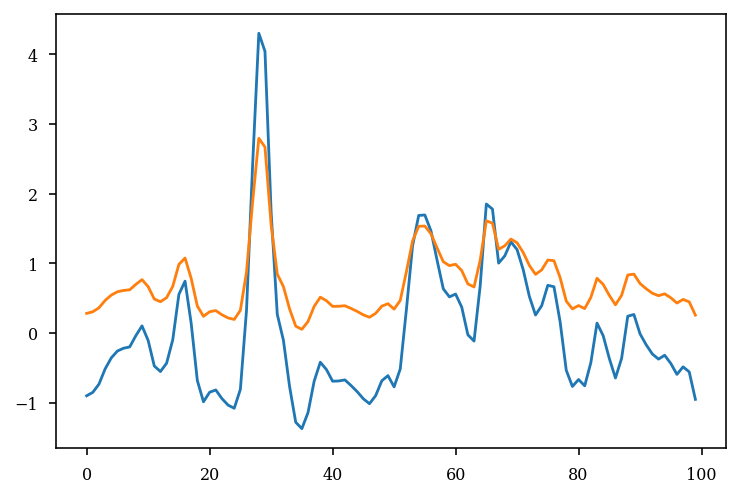

In [117]:
plt.plot(ratemaps_z[2])
plt.plot(ratemaps[2])

<AxesSubplot:>

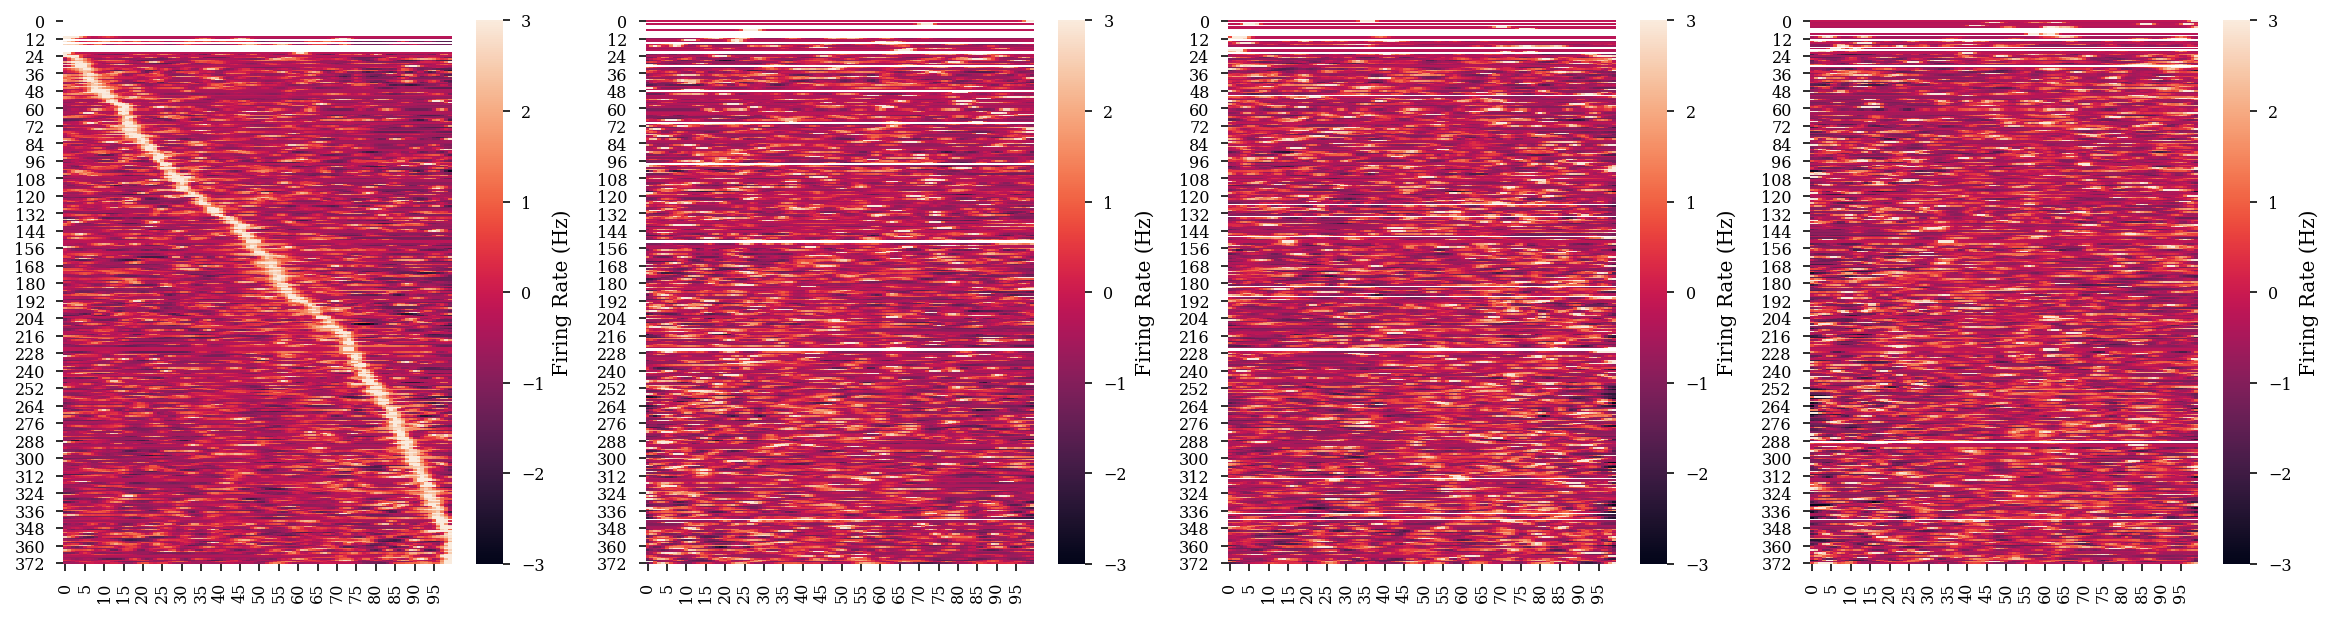

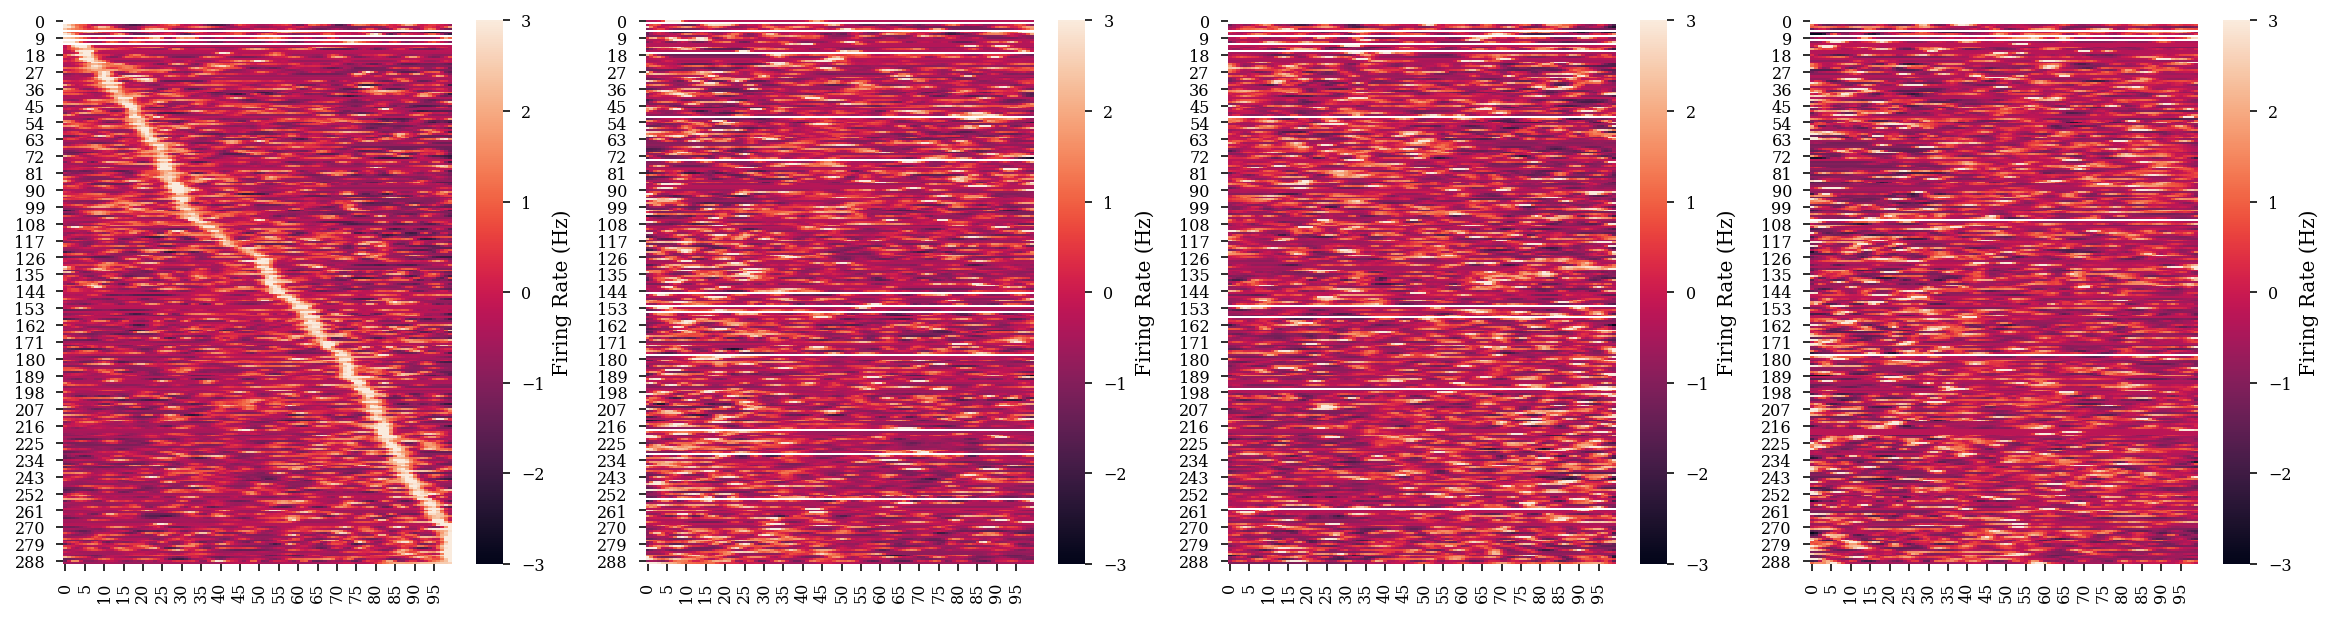

In [111]:
fig,ax = plt.subplots(1,4,figsize=(20,5))

idx = (label_df.trajectory == "center_left") & (label_df.deepSuperficial == "Deep")
temp_ratemap = ratemaps_z[idx]

idx = np.argsort(np.argmax(temp_ratemap,axis=1))
sns.heatmap(temp_ratemap[idx],vmax=3,vmin=-3,ax=ax[0],cbar_kws={'label':'Firing Rate (Hz)'})

temp_ratemap = ratemaps_z[(label_df.trajectory == "left_center") & (label_df.deepSuperficial == "Deep")]
sns.heatmap(temp_ratemap[idx],vmax=3,vmin=-3,ax=ax[1],cbar_kws={'label':'Firing Rate (Hz)'})

temp_ratemap = ratemaps_z[(label_df.trajectory == "center_right") & (label_df.deepSuperficial == "Deep")]
sns.heatmap(temp_ratemap[idx],vmax=3,vmin=-3,ax=ax[2],cbar_kws={'label':'Firing Rate (Hz)'})

temp_ratemap = ratemaps_z[(label_df.trajectory == "right_center") & (label_df.deepSuperficial == "Deep")]
sns.heatmap(temp_ratemap[idx],vmax=3,vmin=-3,ax=ax[3],cbar_kws={'label':'Firing Rate (Hz)'})

fig,ax = plt.subplots(1,4,figsize=(20,5))

idx = (label_df.trajectory == "center_left") & (label_df.deepSuperficial == "Superficial")
temp_ratemap = ratemaps_z[idx]

idx = np.argsort(np.argmax(temp_ratemap,axis=1))
sns.heatmap(temp_ratemap[idx],vmax=3,vmin=-3,ax=ax[0],cbar_kws={'label':'Firing Rate (Hz)'})

temp_ratemap = ratemaps_z[(label_df.trajectory == "left_center") & (label_df.deepSuperficial == "Superficial")]
sns.heatmap(temp_ratemap[idx],vmax=3,vmin=-3,ax=ax[1],cbar_kws={'label':'Firing Rate (Hz)'})

temp_ratemap = ratemaps_z[(label_df.trajectory == "center_right") & (label_df.deepSuperficial == "Superficial")]
sns.heatmap(temp_ratemap[idx],vmax=3,vmin=-3,ax=ax[2],cbar_kws={'label':'Firing Rate (Hz)'})

temp_ratemap = ratemaps_z[(label_df.trajectory == "right_center") & (label_df.deepSuperficial == "Superficial")]
sns.heatmap(temp_ratemap[idx],vmax=3,vmin=-3,ax=ax[3],cbar_kws={'label':'Firing Rate (Hz)'})

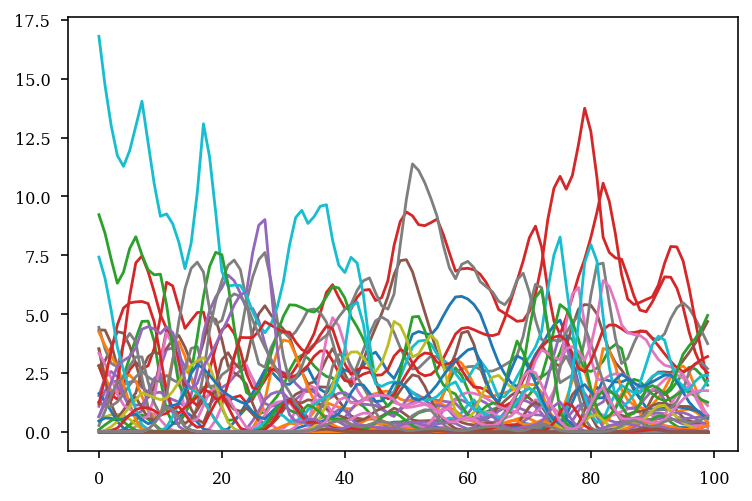

In [70]:
plt.plot(ratemap.T)
plt.show()

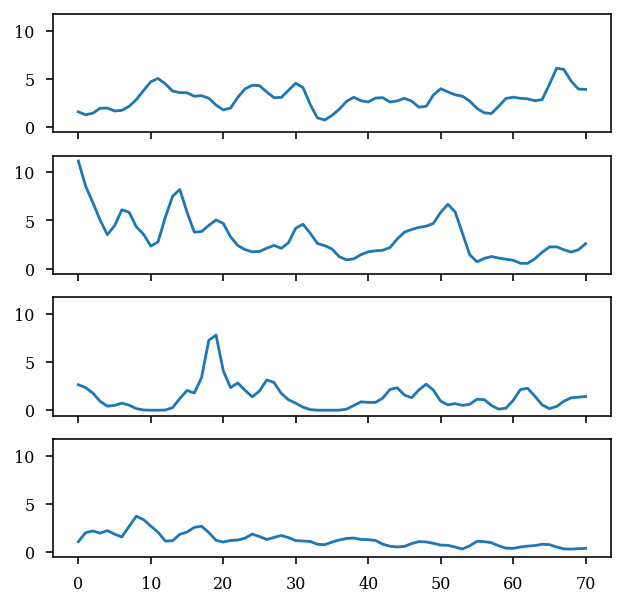

In [38]:
cell = 4
fig,ax = plt.subplots(4,1,figsize=(5,5),sharex=True,sharey=True)
for traj_i,traj in enumerate(trajectories.keys()):

    tc, st_run, bst_run = wmaze_replay.get_tuning_curves(
        pos, st_all.iloc[:,cell], trajectories[traj], speed_thres, ds_50ms, s_binsize, tuning_curve_sigma
    )
    ax[traj_i].plot(tc.ratemap[0])

In [17]:
peak_firing_rates = tc.max(axis=1)
mean_firing_rates = tc.mean(axis=1)
ratio = peak_firing_rates / mean_firing_rates
np.where(
    (cell_metrics.deepSuperficial == "Deep")
    & (tc.ratemap.max(axis=1) > place_cell_min_rate)
    & (st_run.n_events > place_cell_min_spks)
    & (ratio >= place_cell_peak_mean_ratio)
)


(array([ 3,  4, 15, 17, 23, 27, 39, 42, 46], dtype=int64),)